# CNN-BiLSTM-CRF

This notebook is based on the work of "End-to-end Sequence Labelling via Bidirectional LSTM-CNNs-CRF https://arxiv.org/pdf/1603.01354.pdf

RECENT UPDATE: Currently working on writing a custom training loop in order to define early stopping condition on F1 score

In [25]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

from tensorflow.keras import layers # Just for example, delete later

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, concatenate, Embedding, Dense, TimeDistributed, InputSpec, Dropout, Bidirectional, Layer, Conv1D, SpatialDropout1D,GlobalMaxPooling1D, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow_addons.text import crf_decode, crf_log_likelihood

# from keras_contrib.losses import crf_loss
# from keras_contrib.metrics import crf_accuracy

from tf2crf import CRF, ModelWithCRFLoss, ModelWithCRFLossDSCLoss

import nltk
nltk.download('punkt')

from termcolor import colored

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thevindegamboda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
def load_data(file_path):
    file = open(file_path, "r")
    data, entities, sentence, unique_labels = [], [], [], []
    for line in file:
        line = line.strip("\n").split("\t")
        
        if len(line) > 1:
            word = line[0]
            label = line[1]
            
            sentence.append(word)
            entities.append(label)
            
            if label not in unique_labels:
                unique_labels.append(label)
            
        elif len(entities) > 0:
            sentence = " ".join(sentence)
            data.append({"sentence" : sentence, "entities" : entities})
            entities, sentence = [], []
            
    file.close()
    return data, unique_labels

In [27]:
train_dev_filepath = "../data/NERdata/NCBI-disease/train_dev.tsv"
test_filepath = "../data/NERdata/NCBI-disease/test.tsv"

train_data, train_unq_labels = load_data(train_dev_filepath)
test_data, _ = load_data(test_filepath)

data = train_data + test_data

In [28]:
data[0]

{'sentence': 'Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .',
 'entities': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B',
  'I',
  'I',
  'I',
  'O',
  'O']}

In [29]:
#Check how many datapoints and unique labels we have acquired from the dataset

len(data), len(train_unq_labels)

(7287, 3)

In [30]:
#Now we will make reference dictionaries for the text elements

def get_mappings(data, word_ent):

    if word_ent == "word" or word_ent == "char":
        vocab = Counter([i for x in data for i in x['sentence'].split()])
        if word_ent == "char":
            vocab = Counter([i for x in vocab for i in list(x)])
    elif word_ent == "ent":
        vocab = Counter([i for x in data for i in x['entities']])
    
    vocab = [i[0] for i in vocab.most_common()]
    
    idx2tok = {idx:tok for idx, tok in enumerate(vocab, 1)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab, 1)}
    
    return tok2idx, idx2tok


word2idx, idx2word = get_mappings(data, "word")
char2idx, idx2char = get_mappings(data, "char")
tag2idx, idx2tag = get_mappings(data, "ent")

n_words = len(word2idx)
n_chars = len(char2idx)

In [31]:
# We will add a PAD token to consider padding during training

word2idx["UNK"] = n_words + 1
idx2word[n_words + 1] = "UNK"

word2idx["PAD"] = 0
idx2word[0] = "PAD"

char2idx["UNK"] = n_chars + 1
idx2char[n_chars + 1] = "UNK"

char2idx["PAD"] = 0
idx2char[0] = "PAD"

# tag2idx["PAD"] = 0
# idx2tag[0] = "PAD"


assert len(word2idx) == len(idx2word) and len(char2idx) == len(idx2char)

In [32]:
tag2idx

{'O': 1, 'I': 2, 'B': 3}

In [33]:
tag2idx = {i:x for x, i in enumerate(tag2idx.keys())}
idx2tag = {i:x for x, i in tag2idx.items()}

In [34]:
tag2idx, idx2tag

({'O': 0, 'I': 1, 'B': 2}, {0: 'O', 1: 'I', 2: 'B'})

In [35]:
n_words = len(word2idx)
n_chars = len(char2idx)

print("There are {} unique words/elements in the corpus being considered".format(n_words))

There are 10820 unique words/elements in the corpus being considered


For convenience let us create a Pandas df summarising all the relevant data to this point

In [36]:
columns = ["Sentence", "Labels", "Word Tokens", "Label Tokens", "Character Tokens"]

data_df = []
for i in range(len(data)):
    #We want data in the form : [Sentence, Labels, Words Tokens, Label Tokens]
    sentence = data[i]['sentence']
    labels = data[i]['entities']
    words = sentence.split()
    chars = [list(i) for i in words]
    word_tkns = [word2idx.get(i) for i in words]
    label_tkns = [tag2idx.get(i) for i in labels]
    char_tkns = [list(map(char2idx.get, i)) for i in chars]
    
    data_df.append([sentence, labels, word_tkns, label_tkns, char_tkns])
    
data_df = pd.DataFrame(data_df, columns = columns)

In [37]:
data_df.head()

,Sentence,Labels,Word Tokens,Label Tokens,Character Tokens
0,"Identification of APC2 , a homologue of the ad...","[O, O, O, O, O, O, O, O, B, I, I, I, O, O]","[777, 3, 2888, 4, 8, 778, 3, 2, 335, 280, 532,...","[0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0]","[[37, 11, 1, 4, 6, 2, 20, 2, 10, 3, 6, 2, 5, 4..."
1,The adenomatous polyposis coli ( APC ) tumour ...,"[O, B, I, I, I, I, I, I, O, O, O, O, O, O, O, ...","[18, 335, 280, 532, 10, 115, 9, 507, 6, 355, 3...","[0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[[34, 17, 1], [3, 11, 1, 4, 5, 13, 3, 6, 5, 14..."
2,Complex formation induces the rapid degradatio...,"[O, O, O, O, O, O, O, O, O]","[4814, 623, 3363, 2, 1036, 2889, 3, 3362, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[[24, 5, 13, 12, 9, 1, 32], [20, 5, 7, 13, 3, ..."
3,"In colon carcinoma cells , loss of APC leads t...","[O, B, I, O, O, O, O, O, O, O, O, O, O, O, O, ...","[51, 1577, 578, 84, 4, 160, 3, 115, 872, 11, 2...","[0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[37, 4], [10, 5, 9, 5, 4], [10, 3, 7, 10, 2, ..."
4,"Here , we report the identification and genomi...","[O, O, O, O, O, O, O, O, O, O, O, O, O]","[368, 4, 54, 149, 2, 397, 7, 197, 517, 3, 115,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[43, 1, 7, 1], [63], [44, 1], [7, 1, 12, 5, 7..."


<BarContainer object of 3 artists>

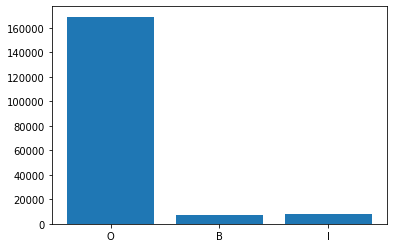

In [38]:
from collections import Counter

labels = [i for x in data_df["Labels"].values for i in x]
cnt = Counter(labels)
plt.bar(cnt.keys(), cnt.values())

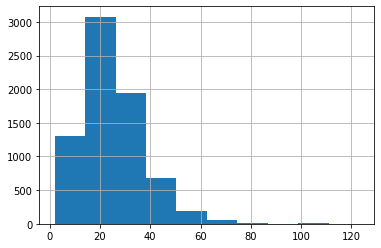

count    7287.000000
mean       25.273364
std        12.583760
min         2.000000
25%        17.000000
50%        23.000000
75%        32.000000
max       123.000000
Name: Word Tokens, dtype: float64

In [39]:
lengths = data_df['Word Tokens'].map(len)

lengths.hist()
plt.show()

lengths.describe()

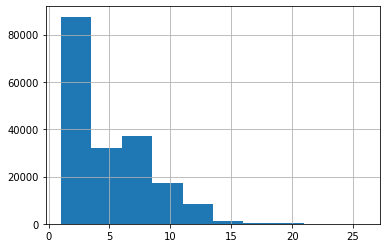

count    184167.000000
mean          4.682104
std           3.334064
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          26.000000
dtype: float64

In [40]:
words = data_df["Character Tokens"]
word_lengths = pd.Series([len(x) for i in words for x in i])

word_lengths.hist()
plt.show()

word_lengths.describe()

In [41]:
MAX_CHAR = 26
MAX_WORD = 123

padded_sentences = pad_sequences(data_df["Word Tokens"], maxlen=MAX_WORD, dtype='int32', padding='post', truncating='post', value= word2idx["PAD"])
padded_labels = pad_sequences(data_df["Label Tokens"], maxlen = MAX_WORD, dtype='int32', padding='post', truncating='post', value= tag2idx["O"])
padded_labels = np.array([to_categorical(i, num_classes = len(tag2idx)) for i in padded_labels])
padded_chars = [pad_sequences(x, maxlen = MAX_CHAR, dtype = 'int32', padding = 'post', truncating = 'post', value= char2idx["PAD"]) for x in data_df["Character Tokens"]]
padded_chars = pad_sequences(padded_chars, maxlen = MAX_WORD, padding = 'post', value = [0]*MAX_CHAR)

no_samples = np.shape(padded_sentences)[0]

In [42]:
idx = list(range(no_samples))

train_idx, val_test_idx = train_test_split(idx, test_size = 0.6, shuffle = True, random_state = 2021)
val_idx, test_idx = train_test_split(val_test_idx, test_size = 0.5)

train_sent, train_chars, train_labels = padded_sentences[train_idx], padded_chars[train_idx], padded_labels[train_idx]
val_sent, val_chars, val_labels = padded_sentences[val_idx], padded_chars[val_idx], padded_labels[val_idx]
test_sent, test_chars, test_labels = padded_sentences[test_idx], padded_chars[test_idx], padded_labels[test_idx]

## Build Model

In [48]:
def get_model(word_vocab_size, char_vocab_size, max_word_len, max_char_len, final_layer = 'softmax', lr = 0.001):
    WORD_EMB_DIM = 64
    CHAR_EMB_DIM = 64

    # Input and Embedding for words
    word_input = Input(shape = (max_word_len,))
    word_emb = Embedding(input_dim=word_vocab_size + 1, output_dim=WORD_EMB_DIM, trainable = True,
                         input_length=max_word_len, mask_zero = True, name = "word_embed")(word_input)
    
    
    
    # Input and Embedding for characters
    char_input= Input(shape = (max_word_len, max_char_len,))
    char_emb = TimeDistributed(Embedding(input_dim = char_vocab_size + 1, output_dim = CHAR_EMB_DIM, trainable = True,
                                        input_length = max_char_len, name = "char_embed"))(char_input)
    
    
    # Character CNN feature extraction with filter of length 3
    char_conv = TimeDistributed(Conv1D(32, 4, padding='same'), name = "td_conv1d")(char_emb)
    char_pool = TimeDistributed(GlobalMaxPooling1D(), name="char_pooling")(char_conv)
    
    # Main LSTM
    x = concatenate([word_emb, char_pool])
    #x = SpatialDropout1D(0.3)(x)
    main_lstm = Bidirectional(LSTM(units=32, return_sequences=True, dropout = 0.5, recurrent_dropout = 0.5), name = 'bilstm')(x)
    
    opt = Nadam(lr=lr, clipnorm = 1.0)
    input_nodes = [word_input, char_input]
    
    if final_layer == 'softmax':
        out = TimeDistributed(Dense(len(tag2idx), activation="softmax"), name = 'tdd')(main_lstm)
        model = Model(input_nodes, out)
        #model.compile(loss = "categorical_crossentropy", optimizer=opt)
    
    elif final_layer == 'crf':
        
        crf = CRF(units = len(tag2idx))

        out = crf(main_lstm)

        model = Model(input_nodes, out)
        #model = ModelWithCRFLoss(base_model, sparse_target=False)

        #model.compile(optimizer=opt)
    
    try:
        model.summary()
    except:
        pass
    
    return model

In [49]:
classifier = 'softmax'

model = get_model(len(word2idx), len(char2idx), MAX_WORD, MAX_CHAR, final_layer = classifier, lr = 0.001)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 123, 26)]    0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 123, 26, 64)  5632        input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 123)]        0                                            
__________________________________________________________________________________________________
td_conv1d (TimeDistributed)     (None, 123, 26, 32)  8224        time_distributed_2[0][0]         
____________________________________________________________________________________________

In [27]:
from tensorflow_addons.text.crf import crf_log_likelihood
from typing import Union

class ModelWithCRFLoss(tf.keras.Model):
    """
    Wrapper around the base model for custom training logic.
    Args:
        base_model: The model including the CRF layer
        sparse_target: if the y label is sparse or one-hot, default True
        metric: the metric for training, default 'accuracy'. Warning: Currently tensorflow metrics like AUC need the output and y_true to be one-hot to cauculate, they are not supported.
    """

    def __init__(self, base_model, sparse_target=True, metric: Union[str, object] = 'accuracy'):
        super().__init__()
        self.base_model = base_model
        self.sparse_target = sparse_target
        self.metric = metric
        if isinstance(metric, str):
            if metric == 'accuracy':
                self.metrics_fn = tf.keras.metrics.Accuracy(name='accuracy')
            else:
                raise ValueError('unknown metric name')
        else:
            self.metrics_fn = self.metric
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

    def call(self, inputs, training=False):
        if training:
            return self.base_model(inputs)
        else:
            return self.base_model(inputs)[0]

    def compute_loss(self, x, y, training=False):
        viterbi_sequence, potentials, sequence_length, chain_kernel = self(x, training=training)
        # we now add the CRF loss:
        crf_loss = -crf_log_likelihood(potentials, y, sequence_length, chain_kernel)[0]
        return viterbi_sequence, sequence_length, tf.reduce_mean(crf_loss)

    def train_step(self, data):
        x, y, sample_weight = unpack_data(data)
        # y : '(batch_size, seq_length)'
        if self.sparse_target:
            assert len(y.shape) == 2
        else:
            y = tf.argmax(y, axis=-1)
        with tf.GradientTape() as tape:
            viterbi_sequence, sequence_length, crf_loss = self.compute_loss(x, y, training=True)
            loss = crf_loss + tf.cast(tf.reduce_sum(self.losses), crf_loss.dtype)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.metrics_fn.update_state(y, viterbi_sequence, tf.sequence_mask(sequence_length, y.shape[1]))
        return {"loss": self.loss_tracker.result(), self.metrics_fn.name: self.metrics_fn.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.metrics_fn]

    def test_step(self, data):
        x, y, sample_weight = unpack_data(data)
        # y : '(batch_size, seq_length)'
        if self.sparse_target:
            assert len(y.shape) == 2
        else:
            y = tf.argmax(y, axis=-1)
        viterbi_sequence, sequence_length, crf_loss = self.compute_loss(x, y, training=True)
        loss = crf_loss + tf.cast(tf.reduce_sum(self.losses), crf_loss.dtype)
        self.loss_tracker.update_state(loss)
        self.metrics_fn.update_state(y, viterbi_sequence, tf.sequence_mask(sequence_length, y.shape[1]))
        return self.loss_tracker.result()

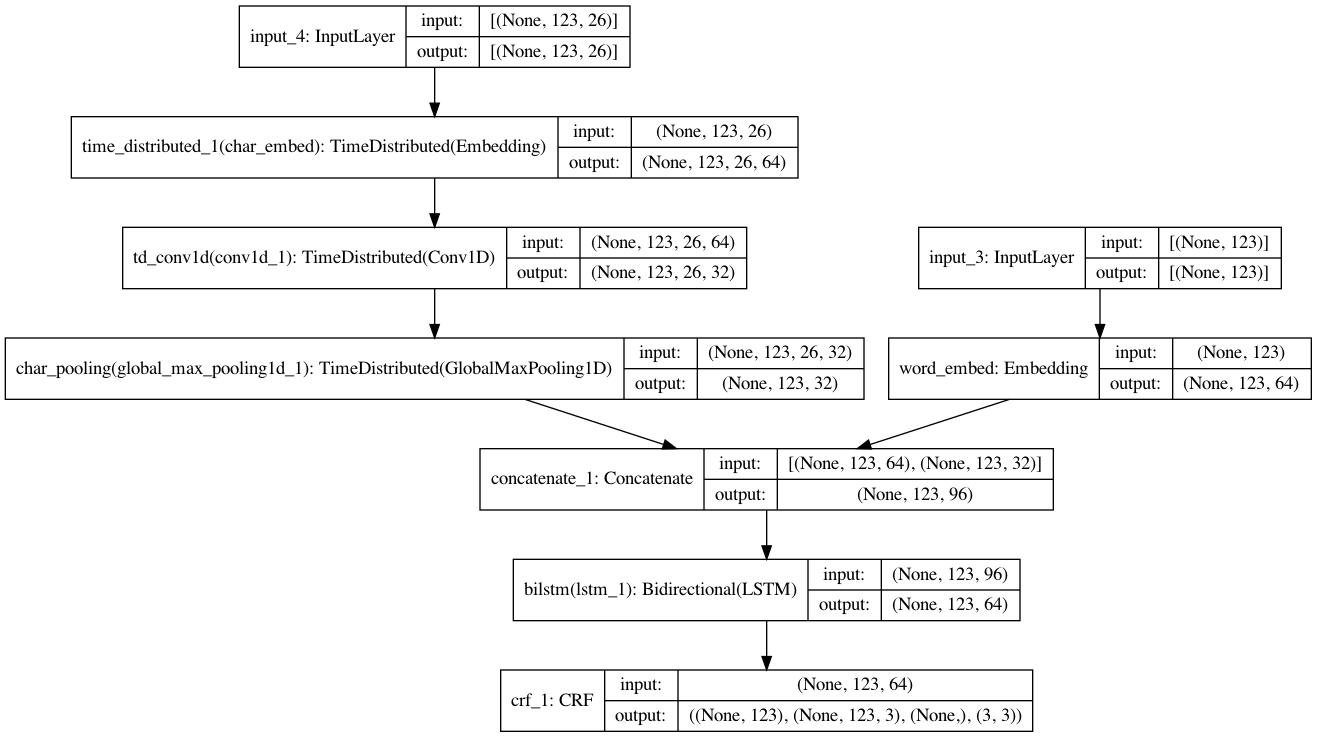

In [45]:
image_filepath = "../docs/char_{}.png".format(classifier)

plot_model(model, to_file = image_filepath, show_shapes = True)

In [50]:
def unpack_data(data):
    if len(data) == 2:
        return data[0], data[1], None
    elif len(data) == 3:
        return data
    else:
        raise TypeError("Expected data to be a tuple of size 2 or 3.")

In [51]:
def chunker(sequence, size, shuffle = False):
    seq = sequence.copy()
    if shuffle == True:
        random.shuffle(seq)
    return [seq[pos:pos + size] for pos in range(0, len(seq), size)]

In [ ]:
def custom_fit_crf(model, loss_fn, optimizer, metric, train_dataset, val_dataset, batch_size, epochs):
    y = tf.argmax(y, axis=-1)
    with tf.GradientTape() as tape:
        viterbi_sequence, sequence_length, crf_loss = self.compute_loss(x, y, training=True)
        loss = crf_loss + tf.cast(tf.reduce_sum(self.losses), crf_loss.dtype)
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_tracker.update_state(loss)
    self.metrics_fn.update_state(y, viterbi_sequence, tf.sequence_mask(sequence_length, y.shape[1]))
    return {"loss": self.loss_tracker.result(), self.metrics_fn.name: self.metrics_fn.result()}

In [52]:
def custom_fit(model, loss_fn, optimizer, metric, train_dataset, val_dataset, batch_size, epochs):
    
    @tf.function
    def train_step(x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)
        return loss_value

    @tf.function
    def test_step(x_batch_val, y_batch_val):
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    
    x_train, y_train = train_dataset
    x_val, y_val = val_dataset
    
    train_acc_metric = metric
    val_acc_metric = metric
    
    for epoch in range(epochs):
    
        train_indices = list(range(len(x_train[0])))
        val_indices = list(range(len(x_val[0])))

        train_batches = chunker(train_indices, batch_size)
        val_batches = chunker(val_indices, batch_size)

        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, batch_indices in enumerate(train_batches):
            batch_sents = x_train[0][batch_indices]
            batch_chars = x_train[1][batch_indices]
            
            x_batch_train = [batch_sents, batch_chars]
            y_batch_train = y_train[batch_indices]

            loss_value = train_step(x_batch_train, y_batch_train)
            
            # Log every 200 batches.
            if step % 200 == 0:
                print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, float(loss_value))
                )
                print("Seen so far: %d samples" % ((step + 1) * 64))

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for batch_indices in val_batches:
            batch_sents = x_val[0][batch_indices]
            batch_chars = x_val[1][batch_indices]
            
            x_batch_val = [batch_sents, batch_chars]
            y_batch_val= y_val[batch_indices]

            test_step(x_batch_val, y_batch_val)
            
        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))

In [53]:
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
opt = Nadam(lr=0.001, clipnorm = 1.0)
metric = keras.metrics.CategoricalAccuracy()
train_dataset = ([train_sent, train_chars], train_labels)
val_dataset = ([val_sent, val_chars], val_labels)
epochs = 7
batch_size = 16

custom_fit(model, loss_fn, opt, metric, train_dataset, val_dataset, batch_size, epochs)


Start of epoch 0
Training loss (for one batch) at step 0: 1.0968
Seen so far: 64 samples
Training acc over epoch: 0.9828
Validation acc: 0.9832
Time taken: 37.50s

Start of epoch 1
Training loss (for one batch) at step 0: 0.9476
Seen so far: 64 samples
Training acc over epoch: 0.9829
Validation acc: 0.9832
Time taken: 35.84s

Start of epoch 2
Training loss (for one batch) at step 0: 0.8785
Seen so far: 64 samples
Training acc over epoch: 0.9829
Validation acc: 0.9832
Time taken: 36.51s

Start of epoch 3
Training loss (for one batch) at step 0: 0.8158
Seen so far: 64 samples
Training acc over epoch: 0.9829
Validation acc: 0.9832
Time taken: 35.88s

Start of epoch 4
Training loss (for one batch) at step 0: 0.7638
Seen so far: 64 samples
Training acc over epoch: 0.9829
Validation acc: 0.9832
Time taken: 38.43s

Start of epoch 5
Training loss (for one batch) at step 0: 0.7230
Seen so far: 64 samples
Training acc over epoch: 0.9829
Validation acc: 0.9832
Time taken: 32.30s

Start of epoch 

## Evaluation